In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [3]:
diabetes = pd.read_csv('pima-indians-diabetes.csv')

In [4]:
diabetes.head(5)

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age,Class,Group
0,6,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,50,1,B
1,1,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,31,0,C
2,8,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,32,1,B
3,1,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,21,0,B
4,0,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,33,1,C


In [7]:
#need to normalize data
features_norm = diabetes.columns.tolist()
features_norm.remove("Age")
features_norm.remove("Class")#target
features_norm.remove("Group") #categorical

In [8]:
features_norm

['Number_pregnant',
 'Glucose_concentration',
 'Blood_pressure',
 'Triceps',
 'Insulin',
 'BMI',
 'Pedigree']

In [10]:
#one can use sklearn.preprocessing but let's just quickly compute a minmax scale with pandas
diabetes[features_norm] = diabetes[features_norm].apply(lambda x: (x-x.min())/(x.max()-x.min()))

In [11]:
diabetes.head()

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age,Class,Group
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,50,1,B
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,31,0,C
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,32,1,B
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,21,0,B
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,33,1,C


In [12]:
#to convert to feature columns of tf. Note, Group isn't numeric so it's not there
num_preg = tf.feature_column.numeric_column('Number_pregnant')
plasma_gluc = tf.feature_column.numeric_column('Glucose_concentration')
dias_press = tf.feature_column.numeric_column('Blood_pressure')
tricep = tf.feature_column.numeric_column('Triceps')
insulin = tf.feature_column.numeric_column('Insulin')
bmi = tf.feature_column.numeric_column('BMI')
diabetes_pedigree = tf.feature_column.numeric_column('Pedigree')
age = tf.feature_column.numeric_column('Age')

In [13]:
#2 ways to deal with categorical, vocabulary list and hash buckets
assigned_group = tf.feature_column.categorical_column_with_hash_bucket(key="Group",hash_bucket_size=10)
#assuming maximum = 10 categorical types. If there's only A,B,C,D -> it will be 4

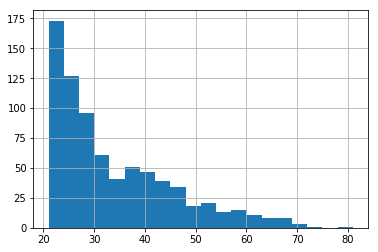

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

diabetes['Age'].hist(bins=20)

# Converting Age into categorical

In [15]:
#we divide the age groups into the listed range.
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[20,30,40,50,60,70,80])

In [16]:
#Important, we put all the TF features into a list
feat_cols = [num_preg ,plasma_gluc,dias_press ,tricep ,insulin,bmi,diabetes_pedigree ,assigned_group, age_buckets]
feat_cols

[_NumericColumn(key='Number_pregnant', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Glucose_concentration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Blood_pressure', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Triceps', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Insulin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='BMI', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Pedigree', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _HashedCategoricalColumn(key='Group', hash_bucket_size=10, dtype=tf.string),
 _BucketizedColumn(source_column=_NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(20, 30, 40, 50, 60, 70, 80))]

In [17]:
x_data = diabetes.drop("Class",axis=1)

In [19]:
x_data.head()

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age,Group
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,50,B
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,31,C
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,32,B
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,21,B
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,33,C


In [20]:
labels=diabetes["Class"] #target

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data,labels,test_size=0.3,random_state=101)

# LinearClassifier with Tensorflow

In [28]:
#Step1: create an input function
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=10,num_epochs=1000,shuffle=True)
#feature_columns is the name of the features only, not the data (in tf version)
model = tf.estimator.LinearClassifier(feature_columns=feat_cols,n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/lw/cnbx1bp507n2clzfjv5hcgqh0000gn/T/tmp40739dq3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a1f2079e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [29]:
model.train(input_fn=input_func,steps=1000) #input function, not feature column names

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/lw/cnbx1bp507n2clzfjv5hcgqh0000gn/T/tmp40739dq3/model.ckpt.
INFO:tensorflow:loss = 6.931472, step = 1
INFO:tensorflow:global_step/sec: 206.458
INFO:tensorflow:loss = 6.3795953, step = 101 (0.483 sec)
INFO:tensorflow:global_step/sec: 368.661
INFO:tensorflow:loss = 6.725348, step = 201 (0.279 sec)
INFO:tensorflow:global_step/sec: 153.892
INFO:tensorflow:loss = 6.600803, step = 301 (0.644 sec)
INFO:tensorflow:global_step/sec: 362.727
INFO:tensorflow:loss

In [31]:
#it's not traning, there should be no more than 1 epochs
test_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test,y=y_test,batch_size=10,num_epochs=1,shuffle=False)
result = model.evaluate(input_fn=test_input_func)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-08-08:14:01
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/lw/cnbx1bp507n2clzfjv5hcgqh0000gn/T/tmp40739dq3/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-08-08:14:02
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.7186147, accuracy_baseline = 0.64935064, auc = 0.8023045, auc_precision_recall = 0.64310634, average_loss = 0.5273896, global_step = 1000, label/mean = 0.35064936, loss = 5.0761247, precision = 0.65384614, prediction/mean = 0.3287663, recall = 0.41975307
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /var/folders/lw/cnbx1bp507n2clzfjv5hcgqh0000gn/T/tmp40739dq3/model.ckpt-1000


In [33]:
result #similar to the training

{'accuracy': 0.7186147,
 'accuracy_baseline': 0.64935064,
 'auc': 0.8023045,
 'auc_precision_recall': 0.64310634,
 'average_loss': 0.5273896,
 'global_step': 1000,
 'label/mean': 0.35064936,
 'loss': 5.0761247,
 'precision': 0.65384614,
 'prediction/mean': 0.3287663,
 'recall': 0.41975307}

In [34]:
#to get prediction, reuse the test data. No y value because we're not training/doing metrics
pred_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test,batch_size=10,num_epochs=1,shuffle=False)
pred = model.predict(input_fn=pred_input_func)

In [36]:
#pred
#need to make it a list to view
pred = list(pred)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/lw/cnbx1bp507n2clzfjv5hcgqh0000gn/T/tmp40739dq3/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [41]:
pred[:3] #examples, a list of dictionaries

[{'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'logistic': array([0.47794393], dtype=float32),
  'logits': array([-0.08828145], dtype=float32),
  'probabilities': array([0.52205604, 0.47794396], dtype=float32)},
 {'class_ids': array([1]),
  'classes': array([b'1'], dtype=object),
  'logistic': array([0.5813214], dtype=float32),
  'logits': array([0.32820022], dtype=float32),
  'probabilities': array([0.4186786, 0.5813214], dtype=float32)},
 {'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'logistic': array([0.3189049], dtype=float32),
  'logits': array([-0.758809], dtype=float32),
  'probabilities': array([0.68109506, 0.31890488], dtype=float32)}]

# Dense Model with Tensorflow

In [43]:
dnn_model = tf.estimator.DNNClassifier(hidden_units=[10,10,10],feature_columns=feat_cols,n_classes=2) #binary classes 
#3 layers of densely connected networks, 10 neurons each layer

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/lw/cnbx1bp507n2clzfjv5hcgqh0000gn/T/tmpu7etsvop', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a211ffef0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [45]:
dnn_model.train(input_fn=input_func) #error because of the categorical data, need to pass it in an embedded column 

INFO:tensorflow:Calling model_fn.


ValueError: Items of feature_columns must be a _DenseColumn. You can wrap a categorical column with an embedding_column or indicator_column. Given: _HashedCategoricalColumn(key='Group', hash_bucket_size=10, dtype=tf.string)

originally defined at:
  File "/Users/vinhta/.local/lib/python3.6/site-packages/tensorflow/python/estimator/canned/dnn.py", line 108, in dnn_logit_fn
    name='dnn')
  File "/Users/vinhta/.local/lib/python3.6/site-packages/tensorflow/python/estimator/canned/dnn.py", line 143, in __init__
    create_scope_now=False)
  File "/Users/vinhta/.local/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column.py", line 323, in __init__
    self._name, _internal_input_layer, create_scope_now_=create_scope_now)
  File "/Users/vinhta/.local/lib/python3.6/site-packages/tensorflow/python/ops/template.py", line 154, in make_template
    **kwargs)


In [48]:
embedded_group_col = tf.feature_column.embedding_column(assigned_group,dimension=4) #A,B,C,D

In [50]:
#reset feature columns, changed assigned_group into embedded_group_col
feat_cols = [num_preg ,plasma_gluc,dias_press ,tricep ,insulin,bmi,diabetes_pedigree ,embedded_group_col, age_buckets]

In [51]:
input_func = tf.estimator.inputs.pandas_input_fn(X_train,y_train,batch_size=10,num_epochs=1000,shuffle=True)

In [52]:
#reuse
dnn_model = tf.estimator.DNNClassifier(hidden_units=[10,10,10],feature_columns=feat_cols,n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/lw/cnbx1bp507n2clzfjv5hcgqh0000gn/T/tmp8s1t76ib', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a1e3099b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [54]:
dnn_model.train(input_fn=input_func,steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/lw/cnbx1bp507n2clzfjv5hcgqh0000gn/T/tmp8s1t76ib/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/lw/cnbx1bp507n2clzfjv5hcgqh0000gn/T/tmp8s1t76ib/model.ckpt.
INFO:tensorflow:loss = 6.7163787, step = 1
INFO:tensorflow:global_step/sec: 247.628
INFO:tensorflow:loss = 6.970589, step = 101 (0.414 sec)
INFO:tensorflow:global_step/sec: 329.282
INFO:tensorflow:loss = 6.082657, step = 201 (0.298 sec)
INFO:tensorflow:global_step/sec: 313.196
INFO:tensorflow:loss = 2.0983756, step = 301 (0.319 sec)
INFO:tensorflow:global_step/sec: 329.518
INFO:tensorflow:loss = 5.5329065, step = 401 (0.302 sec)
INFO:tensorflow:global_step/sec: 329.545
INFO:tensorflow:loss = 5.099719, step = 501 (0.313 sec

In [55]:
eval_input_func = tf.estimator.inputs.pandas_input_fn(X_test,y_test,batch_size=10,num_epochs=1,shuffle=False) #evaluation, so no epochs

In [56]:
dnn_model.evaluate(eval_input_func)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-12-05:58:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/lw/cnbx1bp507n2clzfjv5hcgqh0000gn/T/tmp8s1t76ib/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-12-05:58:14
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.7878788, accuracy_baseline = 0.64935064, auc = 0.8390124, auc_precision_recall = 0.7191454, average_loss = 0.49525234, global_step = 1000, label/mean = 0.35064936, loss = 4.7668037, precision = 0.8076923, prediction/mean = 0.2656408, recall = 0.5185185
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /var/folders/lw/cnbx1bp507n2clzfjv5hcgqh0000gn/T/tmp8s1t76ib/model.ckpt-1000


{'accuracy': 0.7878788,
 'accuracy_baseline': 0.64935064,
 'auc': 0.8390124,
 'auc_precision_recall': 0.7191454,
 'average_loss': 0.49525234,
 'global_step': 1000,
 'label/mean': 0.35064936,
 'loss': 4.7668037,
 'precision': 0.8076923,
 'prediction/mean': 0.2656408,
 'recall': 0.5185185}

Looks like our dnn is about the small as linear system.

In [57]:
#Let's try with different architectures
dnn_model = tf.estimator.DNNClassifier(hidden_units=[15,20,20,20,15],feature_columns=feat_cols,n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/lw/cnbx1bp507n2clzfjv5hcgqh0000gn/T/tmpycssbjyr', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a231e3400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [58]:
dnn_model.train(input_fn=input_func,steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/lw/cnbx1bp507n2clzfjv5hcgqh0000gn/T/tmpycssbjyr/model.ckpt.
INFO:tensorflow:loss = 6.843462, step = 1
INFO:tensorflow:global_step/sec: 212.778
INFO:tensorflow:loss = 6.2847514, step = 101 (0.483 sec)
INFO:tensorflow:global_step/sec: 319.048
INFO:tensorflow:loss = 5.582057, step = 201 (0.310 sec)
INFO:tensorflow:global_step/sec: 335.538
INFO:tensorflow:loss = 4.50136, step = 301 (0.300 sec)
INFO:tensorflow:global_step/sec: 275.018
INFO:tensorflow:loss = 3.6624422, step = 401 (0.375 sec)
INFO:tensorflow:global_step/sec: 249.689
INFO:tensorflow:loss = 5.5698624, step = 501 (0.378 sec)
INFO:tensorflow:global_step/sec: 292.699
INFO:tensorflow:loss = 3.9297874, step = 601 (0.341 sec)
INFO:tensorflow:g

In [59]:
dnn_model.evaluate(eval_input_func)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-12-06:01:53
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/lw/cnbx1bp507n2clzfjv5hcgqh0000gn/T/tmpycssbjyr/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-12-06:01:53
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.7835498, accuracy_baseline = 0.64935064, auc = 0.8550206, auc_precision_recall = 0.73776126, average_loss = 0.45447516, global_step = 1000, label/mean = 0.35064936, loss = 4.3743234, precision = 0.7123288, prediction/mean = 0.3431278, recall = 0.6419753
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /var/folders/lw/cnbx1bp507n2clzfjv5hcgqh0000gn/T/tmpycssbjyr/model.ckpt-1000


{'accuracy': 0.7835498,
 'accuracy_baseline': 0.64935064,
 'auc': 0.8550206,
 'auc_precision_recall': 0.73776126,
 'average_loss': 0.45447516,
 'global_step': 1000,
 'label/mean': 0.35064936,
 'loss': 4.3743234,
 'precision': 0.7123288,
 'prediction/mean': 0.3431278,
 'recall': 0.6419753}

not much better, I supposed